# Golgi Polarization at Wound Edge

The Golgi responds to experimental wounding by reorientating ("polarizing") at the wound edge.

This is an exploratory analysis with the goal of obtaining data such as Golgi orientation angle, Golgi perimeter, Golgi area, the animal it came from, how many hours it's been, etc.

1. Use the 

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.colors as colors

### Ensuring pretty plots ###
plt.style.use('ggplot')
plt.rc('axes', titlesize = 22)
plt.rc('axes', labelsize = 22)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

## Importing tiff stacks into Python


We use `skimage.io.imread()` to load tiff files containing three 16-bit channels (**Green, Blue, Red**). Respectively, they show **Golgi, cell nuclei, and cadherin**.

Not all image readers can understand tiffs with multiple images. RGB image loaders frequently assume that your image is 8-bit where your values range 0 to 255. 


dtype:uint16, shape:(2044, 2048, 3), min:0, max:17180


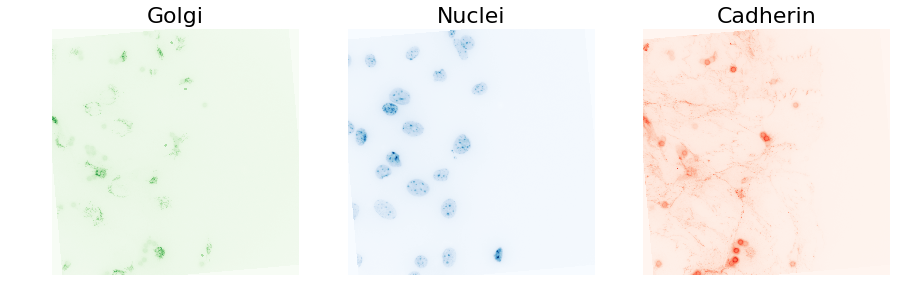

In [59]:
### Importing tiff stack images with skimage.io.imread
from skimage import io

imdir = 'C:/Users/letmedoit/endothelial Polarization-exp 1/processeddata/Animal-1-4hrs-marked/'
# loads to numpy array
imarrayGBR = io.imread(imdir + 'Animal 1_4hrs_002-edit.tif')


print("dtype:{}, shape:{}, min:{}, max:{}".format(
    imarrayGBR.dtype, imarrayGBR.shape, imarrayGBR.min(), imarrayGBR.max()))

### N.B. The order is green, blue, red
colors = ['Greens', 'Blues', 'Reds']
names = ['Golgi', 'Nuclei', 'Cadherin']

## Plotting under this line ##
fig, ax = plt.subplots(1, 3, figsize=(15,15))

for i, (color, name) in enumerate(zip(colors, names)):
    ax[i].imshow(imarrayGBR[:,:,i], cmap=color)
    ax[i].set_title(name)
    ax[i].set_axis_off()

In [60]:
def show_image(image_array, color = 'gray', title = '', vmax = None):
    colors_and_cmaps = {'gray':'gray', 'green':'Greens',
                      'blue':'Blues', 'red':'Reds'}
    plt.figure(figsize = (9, 9))
    plt.imshow(image_array,
               vmax = vmax,
               cmap = colors_and_cmaps[color])
    plt.xlabel('Pixel [x]')
    plt.ylabel('Pixel [y]')
    plt.title(title)
    plt.colorbar()

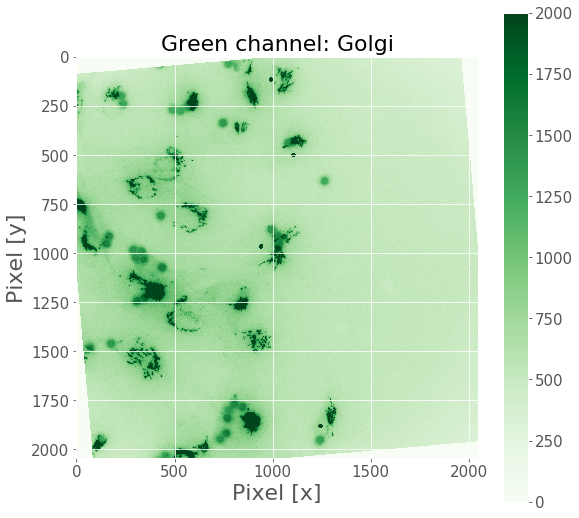

In [61]:
# The first image in the tif stack is green
image_array = imarrayGBR[:,:,0] 

show_image(image_array, color='green', title='Green channel: Golgi', vmax=2000)

## ROI designation

Cynthia marked cells along the wound edge since these would be the ones to re-orient. The Fiji spray paint tool creates circles (assuming the mouse is held down enough) with a specific pixel intensity. __Unfortunately, the specific pixel intensity varies between images.__

By inspection, we note that the spray can value varies between 1500 and 3500. 

Text(0,0.5,'Pixel [y]')

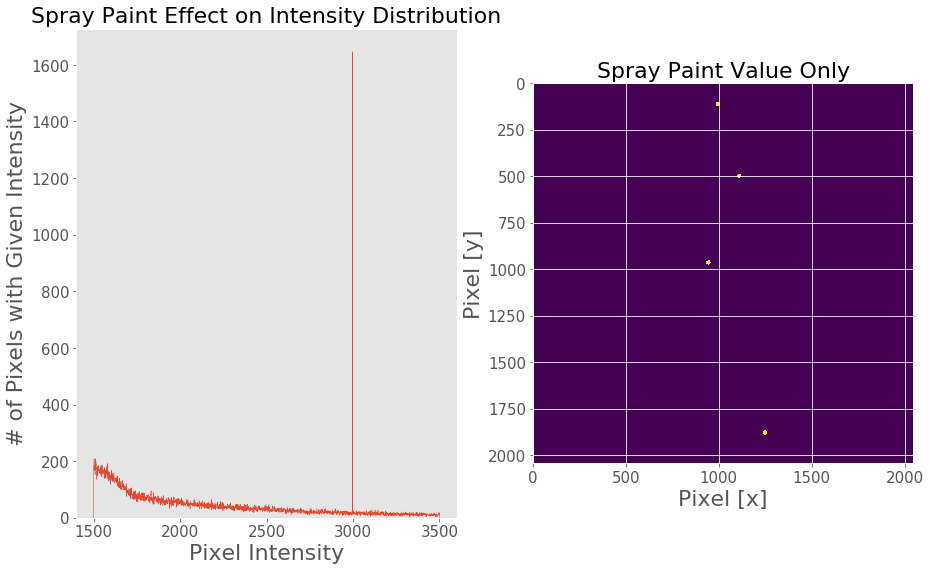

In [62]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

n, bins, _ = ax[0].hist(image_array.flatten(),
                            range=(1500,3500),
                            bins=2000,
                            histtype='step')

ax[0].set_xlabel('Pixel Intensity')
ax[0].set_ylabel('# of Pixels with Given Intensity')
ax[0].set_title('Spray Paint Effect on Intensity Distribution')
ax[0].grid('off')

# Within the range (1500,3500), the spray-can intensity
# is found the most and can be selected this way  
spray_value = int(bins[n.argmax()])

# mask to select pixels matching spray-can value
spray_array = image_array == spray_value

ax[1].imshow(spray_array)

ax[1].set_title('Spray Paint Value Only')
ax[1].set_xlabel('Pixel [x]')
ax[1].set_ylabel('Pixel [y]')

In [63]:
def get_spray_can_value(green_image_array, pixel_range=(1500,3500)):
    """Returns [int], the most probable pixel intensity for spraycan
    
    Keyword arguments
    --------------------    
    green_image_array [2D array]
        The image channel (green) marked with spraycan
        
    pixel_range [tuple]
        The range of intensity values.
        Make sure your range avoids the absolute maxima
    """
    image_array = np.array(green_image_array)
    
    n, bins, _ = ax[0].hist(image_array.flatten(),
                            range = pixel_range,
                            bins = pixel_range[1] - pixel_range[0]
                           )
    spray_value = int(bins[n.argmax()])
    
    return spray_value

We can make a binary image to really see the spray painted values.

Currently `sprayarray` is a 2D boolean array. We want to get the indices where the values are True, and we'll use the indices as (x,y) pairs for cluster analysis. 

In [64]:
x,y = np.where(spray_array==True)
X = np.array((x,y)).T

print('X.shape: {}'.format(X.shape))
print('X: {}'.format(X))

X.shape: (1646, 2)
X: [[ 103  988]
 [ 103  989]
 [ 103  990]
 ..., 
 [1890 1248]
 [1890 1249]
 [2018  556]]


### Determine amount of cells with DBSCAN

DBSCAN requires two parameters
- $\epsilon$, the maximum distance between two samples for them to be considered as in the same neighborhood
- `min_samples`, the number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself

Noise is removed in a well-defined manner.

In [65]:
## Thanks to dbscan documentation
## http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

from sklearn.cluster import DBSCAN
db = DBSCAN(eps=50, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Unique labels: {}'.format(unique_labels))

Estimated number of clusters: 4
Unique labels: {0, 1, 2, 3, -1}


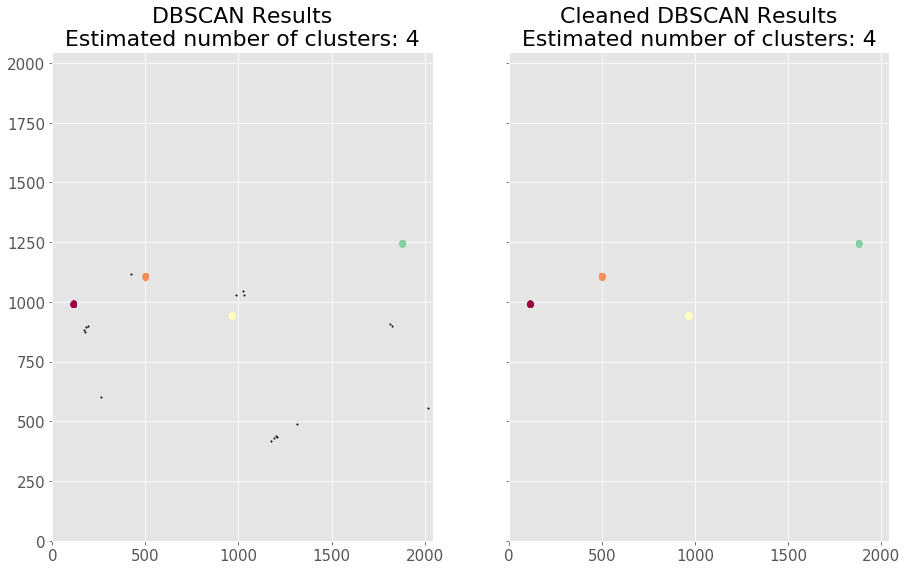

In [66]:
fig, ax = plt.subplots(1,2, figsize=(15,9),
                       sharex=True,sharey=True)

spray_paint_centers = []
max_spray_size = 60 #pixels
# the actual sprays are ~21 pixels wide, so this is generous
bad_labels = [-1]

colors = [plt.cm.Spectral(each)
         for each in np.linspace(0,1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    ax[0].plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), markersize=1)
    
    if k != -1:        # Ignore noise
        dx = np.max(xy[:,0]) - np.min(xy[:,0])
        dy = np.max(xy[:,1]) - np.min(xy[:,1])
        #print(dx, dy)
        if max(dx,dy) < max_spray_size:
            ax[1].plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
            markeredgecolor=tuple(col), markersize=1)
            
            spray_paint_centers.append(
                [np.rint( np.min(xy[:,0]) + dx/2)  ,
                 np.rint( np.min(xy[:,1]) + dy/2)])
        else:
            badlabels.append(k)    

    xy = X[class_member_mask & ~core_samples_mask]
    ax[0].plot(xy[:,0], xy[:,1], 'o', markerfacecolor='k',
            markeredgecolor='k', markersize=1)
    

ax[0].set_xlim([0, image_array.shape[0]])
ax[0].set_ylim([0, image_array.shape[1]])

ax[0].set_title(
    'DBSCAN Results\nEstimated number of clusters: {}'.format(
        n_clusters_))
ax[1].set_title(
    'Cleaned DBSCAN Results\nEstimated number of clusters: {}'.format(
        n_clusters_))

spray_paint_center_array = np.array(spray_paint_centers).astype(int)

If you're paying attention, you'll realize that this plot looks similar to the previous image.
The origin for this plot is lower-left while the origin for the image is at the upper-left. This is a minor annoyance and can be managed; let's demonstrate that we understand how to go back to an image.

Text(0,0.5,'Pixel [y]')

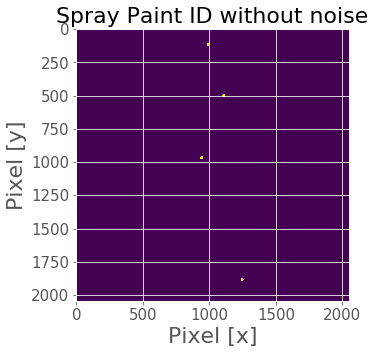

In [67]:
good_labels = ~np.in1d(labels, bad_labels)
good_X = X[good_labels]

to_be_filled = np.zeros_like(spray_array)
to_be_filled[good_X[:,0], good_X[:,1]] = 1
rotated_XY = np.rot90(to_be_filled, 0)

## Plotting under this line ##
plt.figure(figsize=(5,5))

plt.imshow(rotated_XY)

plt.title('Spray Paint ID without noise')
plt.xlabel('Pixel [x]')
plt.ylabel('Pixel [y]')

In [68]:
def get_ROI_pixels(image_array, center, ROI_side=222):
    """Return a box section of your original image array 
    
    Keyword arguments
    --------------------
    imagearray: [array]
        The image array to be sectioned
        
    center: [list] or [tuple] 
        pixel coordinates of ROI centroid given as either 
        a list [x,y] or a tuple (x,y)  
        
    ROIside: [int] (default: 222 pixels)
        side length in pixels of desired box 
    """
    assert ROI_side % 2 == 0, "Give an even ROIside"
    
    # Make a copy instead of referencing original
    new_image = np.array(image_array)
    
    halfside = ROI_side/2
    x = center[0]
    y = center[1]
    
    upper = int(x + halfside)
    lower = int(x - halfside)
    right = int(y + halfside)
    left  = int(y - halfside)

    return new_image[lower:upper, left:right]

### Removing Spray Paint from the image

In [95]:
def remove_spray_can_feature(image_array, spray_can_value):
    """Returns an image array where the pixels with spraycanvalue are
    mapped to another value
    
    Keyword arguments
    --------------------
    imagearray: [array]
        The image array to be sectioned
        
    spraycanvalue: [int]
        An integer value to be removed and replaced by the median of the image
    """ 
    # Make a copy instead of referencing original
    new_image = np.array(image_array)
    
    flat_ROI = new_image.flatten()
    
    ROI_median = np.percentile(flat_ROI, 50)
    #ROI_new_val = np.percentile(flat_ROI, 25)
    
    spray_mask = new_image == spray_can_value
    new_image[spray_mask] = ROI_median
    
    return new_image

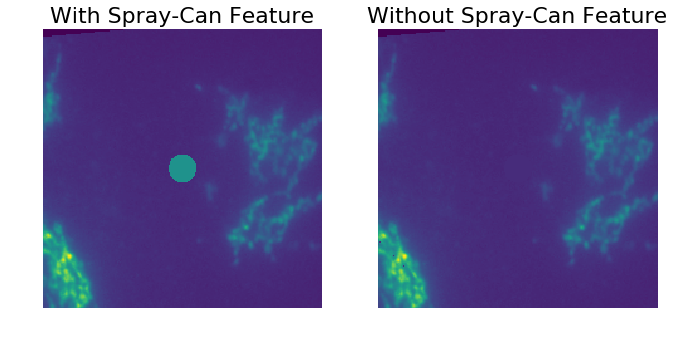

In [96]:
# From the entire image, select the region of interest.
first_ROI = get_ROI_pixels(image_array, spray_paint_centers[0])

# Remove the spray-can feature from the region of interest
ROI_no_spray = remove_spray_can_feature(image_array=first_ROI,
                                     spray_can_value=spray_value)

## Plotting under this line ##
fig, ax = plt.subplots(1,2, figsize=(11,11))

ax[0].imshow(first_ROI)
ax[0].set_title('With Spray-Can Feature')
ax[0].set_axis_off()

ax[1].imshow(ROI_no_spray)
ax[1].set_title('Without Spray-Can Feature')
ax[1].set_axis_off()

Now that our ROI is corrected, we can start processing it.

We will take a look at a handful of different image thresholding techniques:
- Otsu's method
- Yen
- Li

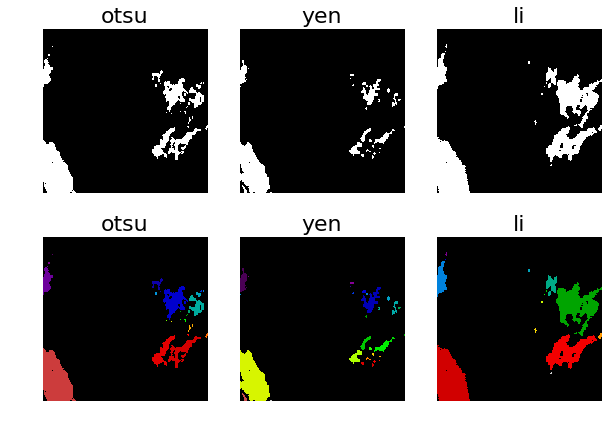

In [71]:
from skimage import filters
from skimage import measure

val_otsu = filters.threshold_otsu(ROI_no_spray)
val_yen = filters.threshold_yen(ROI_no_spray)
val_li  = filters.threshold_li(ROI_no_spray)

names = ['otsu', 'yen', 'li']
methods = [val_otsu, val_yen, val_li]

all_labels_list = []
masks = []

for method in methods:
    mask = ROI_no_spray > method
    masks.append(mask)

    all_labels = measure.label(mask, connectivity=2, background=0)
    all_labels_list.append(all_labels)


## Plotting under this line ##
fig, ax = plt.subplots(2, 3, figsize=(10,7))
ax = ax.ravel()

for i, (name, mask, label) in enumerate(zip(names, masks, all_labels_list)):
    ax[i].imshow(mask, cmap='gray')
    ax[i+3].imshow(label, cmap='nipy_spectral')

    ax[i].set_title(name)
    ax[i+3].set_title(name)
    ax[i].grid('off')
    ax[i+3].grid('off')
    ax[i].set_axis_off()
    ax[i+3].set_axis_off()

After discussion with Cynthia, the postdoc/domain expert, we chose to go with Otsu's method since its segmentation aligns well with the Golgi.

We notice that the Golgi appears to be disjointed even though it's all one thing. We can use DBSCAN to combine them into one cluster.


Estimated number of clusters: 3
Unique labels: {0, 1, 2, -1}


Text(0.5,1,'Estimated number of clusters: 3')

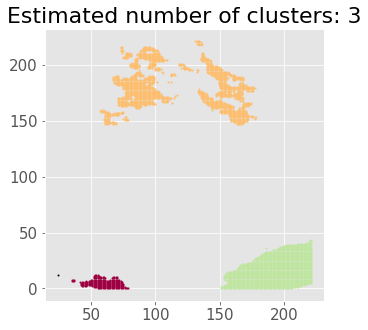

In [72]:
otsu_mask = ROI_no_spray > val_otsu

# At this point otsu_mask is a 2D boolean array
# We must convert it into x,y pairs
xotsu, yotsu = np.where(otsu_mask==True)
XYotsu = np.array((xotsu, yotsu)).T

## Start DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=10, min_samples=10).fit(XYotsu)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Unique labels: {}'.format(unique_labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(5,5))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = XYotsu[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), markersize=1)

    xy = XYotsu[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)

Recall that the image-coordinate system has the origin at top-left with y increasing down. A (clockwise) 90-degree rotation is needed to go from this "normal" convention back to image-convention

For example, in this coordinate system, higher y-values are actually "more to the right" in the image-convention

Since these cells were chosen as edge cases and the wound is to the right, we can exploit this knowledge to select the correct cluster. 

I will do calculations here and rotate the final image.
You can do whatever makes you happy.


In [73]:
# Get the clusters into an easily slicable variable
XYclusters = [XYotsu[labels == label] for label in unique_labels
             if label != -1] # Ignore the noise labels

# Determine the desired Golgi
# knowing that the one we want will have
# the highest Y-value in this coordinate system
maxY = [np.max(cluster[:,1]) for cluster in XYclusters]
golgi = XYclusters[np.argmax(maxY)]

unweighted centroid:[ 117.11390668  179.46935041]
25.497504
95.1573311117
(117.1139066788655, 179.46935041171088)


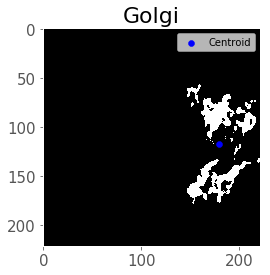

In [74]:
golgi_mean = golgi.mean(axis=0)
print('unweighted centroid:{}'.format(golgi_mean))

to_be_filled = np.zeros_like(ROI_no_spray)
to_be_filled[golgi[:,0], golgi[:,1]] = 1
golgi_rotated = np.rot90(to_be_filled, 0)

# Obtain Golgi properties. 
properties = measure.regionprops(golgi_rotated, cache=False)[0]

area, perimeter, centroid = [properties[key] 
            for key in ['area', 'perimeter','centroid']]

MICRONS_PER_PIXEL = 0.108

print(area*MICRONS_PER_PIXEL**2)
print(perimeter*MICRONS_PER_PIXEL)
print(centroid)



## Plotting under this line ##

plt.imshow(golgi_rotated, label='Nucleus', cmap='gray')
# note that the centroid's x and y are switched
plt.scatter(centroid[1], centroid[0], c='b', label='Centroid')
plt.grid('off')
plt.title('Golgi')
plt.legend()

In [75]:
#def getGolgiValues(green_image_array, spray_can_value, )

### Determining centroid of a nucleus



In [76]:
blue_image_array = imarrayGBR[:,:,1]
#print(blueimarray.dtype, blueimarray.shape, blueimarray.min(), blueimarray.max())

In [77]:
def obtain_nucleus_centroids(spray_paint_centers, blue_image_array):
    """Returns a numpy array of nucleus centroids
    
    Keyword arguments
    --------------------
    spray_paint_centers: [1D array with elements [x,y]]
        1D array containing the pixel locations of various ROI centers
        
    blue_image_array: [2D image array]
        2D image array
        
    Uses Otsu's Method for image segmentation.
    """
    
    n_cells = len(spray_paint_centers)
    nucleus_centroids = []
    image_array = np.array(blue_image_array)
    
    for i, cell in enumerate(spray_paint_centers):
        #print(i, cell)
        blue_ROI = get_ROI_pixels(image_array, cell)
        
        # Use Otsu's Method to separate foreground from background
        val_otsu_blue = filters.threshold_otsu(blue_ROI)
        binary_mask_blue = blue_ROI > val_otsu_blue

        # Apply Euclidean Distance Transform to the binary image
        blue_distance = ndi.distance_transform_edt(binary_mask_blue)

        # Obtain the local maxima using distance to the background
        blue_local_maxi = peak_local_max(blue_distance,
                                    min_distance=23, # ~ cell radius in pixels
                                    exclude_border=True,
                                    indices=False,
                                    labels=binary_mask_blue)

        # Mark the maxima
        blue_markers, nfeatures = ndi.label(blue_local_maxi)

        # Apply watershed segmentation. Don't forget about the negative!
        # The negative is important because `watershed` expects minima
        blue_labels = watershed(-blue_distance, blue_markers,
                           mask = binary_mask_blue)
        
        ## Get the pixel indices for the desired nucleus
        
        for label in blue_labels:
            x, y = np.where(blue_labels==label)
            X = np.array((x,y)).T
            cent = X.mean(axis=0)
        
        #print("centroid: {}".format(cent))

        to_be_filled = np.zeros_like(first_blue_ROI)
        to_be_filled[X[:,0], X[:,1]] = 1
        X = np.rot90(to_be_filled, 0)
        ## Check for multiple nuclei 
        #print(np.min(blue_ROI), np.max(blue_ROI))
        #plt.imshow(blue_ROI)
        
        
        #blue_val_otsu = filters.threshold_otsu(blue_ROI)
        #blue_mask = blue_ROI > blue_val_otsu
        
        #blue_all_labels = measure.label(blue_mask, connectivity=2)
        #blue_properties = measure.regionprops(label_image = blue_all_labels)
        
        #blue_areas = [prop.area for prop in blue_properties]
        
        #blue_largest_index = np.argmax(blue_areas)
        
        #blue_largest_centroid = blue_properties[blue_largest_index].centroid
        #plt.scatter(blue_largest_centroid[0], blue_largest_centroid[1], c='white')
        #nucleus_centroids.append(blue_largest_centroid)

    return np.array(nucleus_centroids)

In [78]:
## Check to see if there are overlapping nuclei that could throw off the centroid 
## (see 'Animal 1_4hrs_002-edit.tif')

#def checkForNonRoundness(imagearray):
    

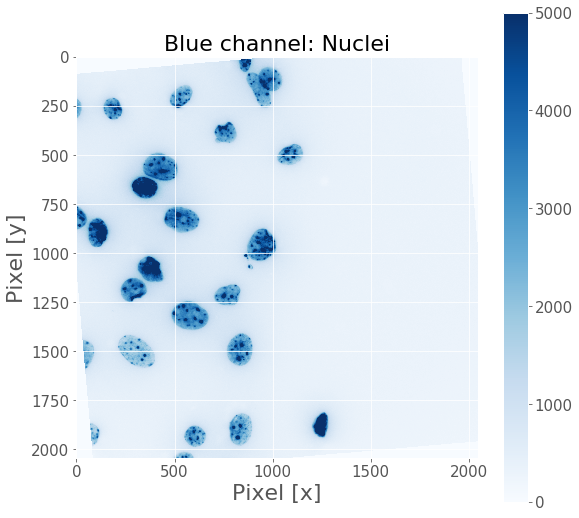

In [79]:
show_image(blue_image_array, color='blue', title='Blue channel: Nuclei', vmax=5000)

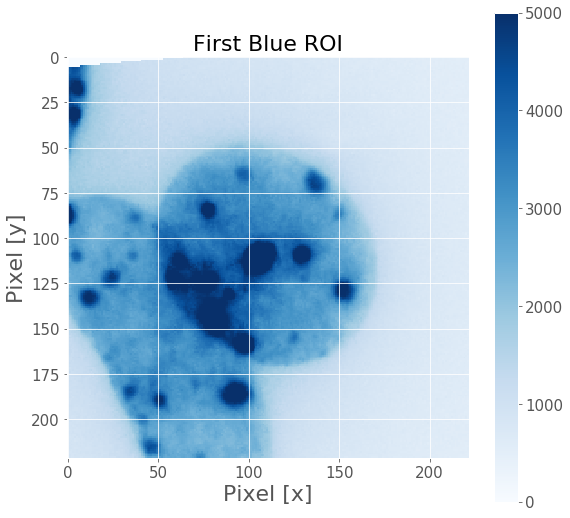

In [80]:
first_blue_ROI = get_ROI_pixels(blue_image_array, spray_paint_centers[0])
show_image(first_blue_ROI, color='blue', title='First Blue ROI', vmax=5000)

## Overlapping nuclei require image segmentation
We have overlapping nuclei. Instead of crying and/or ignoring this region, let's get to work.

First we'll do a binary segmentation to separate foreground from background.

Then we'll hit 'em with a watershed segmentation to separate the objects.

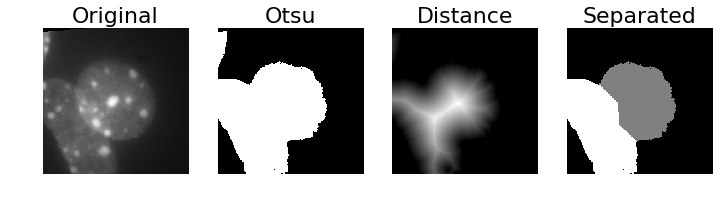

In [81]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# Use Otsu's Method to separate foreground from background
val_otsu_blue = filters.threshold_otsu(first_blue_ROI)
binary_mask_blue = first_blue_ROI > val_otsu_blue

# Apply Euclidean Distance Transform to the binary image
first_blue_distance = ndi.distance_transform_edt(binary_mask_blue)

# Obtain the local maxima using distance to the background
first_blue_local_maxi = peak_local_max(first_blue_distance,
                                    min_distance=23, # ~ cell radius in pixels
                                    exclude_border=True,
                                    indices=False,
                                    labels=binary_mask_blue)

# Mark the maxima
first_blue_markers, nfeatures = ndi.label(first_blue_local_maxi)

# Apply watershed segmentation. Don't forget about the negative!
# The negative is important because `watershed` expects minima
first_blue_labels = watershed(-first_blue_distance, first_blue_markers,
                           mask = binary_mask_blue)


## Plotting under this line ##

# Group for plotting
first_blue_titles = ['Original', 'Otsu', 'Distance','Separated']
first_blue_to_plot = [first_blue_ROI, binary_mask_blue,
                      first_blue_distance, first_blue_labels]

fig, axes = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True,
                        subplot_kw={'adjustable':'box-forced'})
ax = axes.ravel()

for i, (title, method) in enumerate(
                zip(first_blue_titles, first_blue_to_plot)):
    ax[i].axis('off')
    ax[i].imshow(method, cmap='gray')
    ax[i].set_title(title)

Now that we have separate regions, we can calculate centroids and also determine which region is the desired nucleus.

We know that our nucleus is going to be near the center of our image, so let's calculate the centroid for each region and choose the one that is closest.


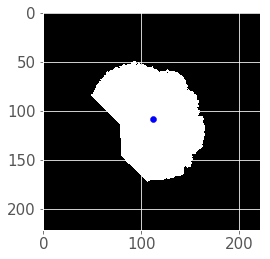

In [82]:
## Get the pixel indices for the desired nucleus
middle = np.array(list(first_blue_labels.shape)) / 2
#print(np.unique(firstbluelabels))

distance_list = []
centroid_list = []
XYnuclei_list = []

for label in np.unique(first_blue_labels):
    x, y = np.where(first_blue_labels==label)
    XY = np.array((x,y)).T
    XYnuclei_list.append([XY])
    cent = XY.mean(axis=0)
    centroid_list.append(cent)
    distance = np.linalg.norm(np.abs(cent - middle))
    distance_list.append(distance)

XYnuclei_array = np.array(XYnuclei_list)

distances = np.array(distance_list)
minindex = np.argmin(distances)

to_be_filled = np.zeros_like(first_blue_labels)
to_be_filled[XYnuclei_array[minindex][0][:,0],
             XYnuclei_array[minindex][0][:,1]] = 1
X = np.rot90(to_be_filled, 0)

## Plotting under this line ##

plt.imshow(X, label='Nucleus', cmap='gray')
plt.scatter(centroid_list[minindex][1],
            centroid_list[minindex][0],
            c='b', label='Centroid')

#plt.legend()

In [83]:
props = measure.regionprops(X, cache=False)
#### Don't forget to convert these to microns at the end
print(props[0]['area']*MICRONS_PER_PIXEL**2, props[0]['perimeter'])

108.918432 425.244732728


In [84]:
bluecent = obtain_nucleus_centroids(spray_paint_centers, blue_image_array)
bluecent

## These pixel values are relative to the spraypaint centers

array([], dtype=float64)

In [85]:
spray_paint_centers

[[114.0, 992.0], [500.0, 1108.0], [964.0, 942.0], [1880.0, 1246.0]]

In [86]:
def get_spray_can_centers(green_array, spray_value,
                          want_plots=False, out_dir="",
                         image_name=""):
    
    # mask to select pixels matching spray-can value
    spray_array = green_array == spray_value
    
    # Currently sprayarray is a 2D boolean array.
    # We want to get the indices where the values are True,
    # and we'll use the indices as (x,y) pairs for cluster analysis.
    x, y = np.where(spray_array == True)
    X = np.array( (x,y)).T
    
    ## Determine cells with DBSCAN 
    ## http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
    
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=50, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    unique_labels = set(labels)
    
    # Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

    if want_plots:
        fig, ax = plt.subplots(1,2, figsize=(15,9),
                               sharex=True,sharey=True)
    
    spray_can_centers_array = []
    max_spray_size = 60 # pixels
    bad_labels = []
    
    colors = [plt.cm.Spectral(each)
         for each in np.linspace(0,1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        if want_plots:
            ax[0].plot(xy[:,0], xy[:,1], 'o',
                       markerfacecolor=tuple(col),
                       markeredgecolor=tuple(col),
                       markersize=1)

        if k != -1:        # Ignore noise
            dx = np.max(xy[:,0]) - np.min(xy[:,0])
            dy = np.max(xy[:,1]) - np.min(xy[:,1])
            
            # There's a large spray in at least one image
            if max(dx,dy) < max_spray_size:
                if want_plots:
                    ax[1].plot(xy[:,0], xy[:,1], 'o',
                               markerfacecolor=tuple(col),
                               markeredgecolor=tuple(col),
                               markersize=1)

                spray_can_centers_array.append(
                    [np.rint( np.min(xy[:,0]) + dx/2)  ,
                     np.rint( np.min(xy[:,1]) + dy/2)])
            else:
                bad_labels.append(k)    

        xy = X[class_member_mask & ~core_samples_mask]
        if want_plots:
            ax[0].plot(xy[:,0], xy[:,1], 'o', markerfacecolor='k',
                       markeredgecolor='k', markersize=1)

    if want_plots:
        ax[0].set_xlim([0, green_array.shape[0]])
        ax[0].set_ylim([0, green_array.shape[1]])

        ax[0].set_title(
            'DBSCAN Results\nEstimated number of clusters: {}'.format(
                n_clusters_))
        
        n_cleaned_clusters_ = len(set(range(n_clusters_)) - set(bad_labels))
        ax[1].set_title(
            'Cleaned DBSCAN Results\nEstimated number of clusters: {}'.format(
                n_cleaned_clusters_))
        
        plt.savefig("{}/{}_{}.png".format(
            out_dir, image_name, "Golgi_spray_paints"))
        plt.close()
    return spray_can_centers_array

In [87]:
def analyze_Golgi_ROI(ROI_no_spray,
                      want_plots=False,
                      out_dir="",
                      image_name=""):
    """Returns area [square microns], perimeter [microns] and centroid [pixel]
    
    """
    from skimage import filters
    from skimage import measure
    
    # Apply Otsu's method
    val_otsu = filters.threshold_otsu(ROI_no_spray)
    otsu_mask = ROI_no_spray > val_otsu

    # At this point otsu_mask is a 2D boolean array
    # We must convert it into x,y pairs
    xotsu, yotsu = np.where(otsu_mask==True)
    XYotsu = np.array((xotsu, yotsu)).T

    ## Start DBSCAN
    from sklearn.cluster import DBSCAN

    db = DBSCAN(eps=10, min_samples=10).fit(XYotsu)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    unique_labels = set(labels)

    # Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

    
    # Get the clusters into an easily slicable variable
    XYclusters = [XYotsu[labels == label] for label in unique_labels
                 if label != -1] # Ignore the noise labels
    # Determine the desired Golgi
    # knowing that the one we want will have
    # the highest Y-value in this coordinate system
    maxY = [np.max(cluster[:,1]) for cluster in XYclusters]
    golgi = XYclusters[np.argmax(maxY)]
    
    golgi_mean = golgi.mean(axis=0)
    
    to_be_filled = np.zeros_like(ROI_no_spray)
    to_be_filled[golgi[:,0], golgi[:,1]] = 1
    golgi_rotated = np.rot90(to_be_filled, 0)

    # Obtain Golgi properties. 
    properties = measure.regionprops(golgi_rotated, cache=False)[0]

    area, perimeter, centroid = [properties[key] 
                for key in ['area', 'perimeter','centroid']]

    MICRONS_PER_PIXEL = 0.108
    
    area = area*MICRONS_PER_PIXEL**2
    perimeter = perimeter*MICRONS_PER_PIXEL

    if want_plots:
        fig, ax = plt.subplots(1,2, figsize=(12,6),
                               sharex=True,sharey=True)
        ## Plotting under this line ##
        ax[0].imshow(ROI_no_spray, cmap='gray')
        ax[1].imshow(golgi_rotated, label='Golgi', cmap='gray')
        # note that the centroid's x and y are switched
        ax[1].scatter(centroid[1], centroid[0], c='b', label='Centroid')
        ax[0].grid('off')
        ax[1].grid('off')
        ax[0].set_title('ROI')
        ax[1].set_title('Golgi_selection')
        #plt.legend()
        
        plt.savefig("{}{}_{}_{}_{}.png".format(
            out_dir, image_name, "Golgi_centroid",
            round(centroid[1],1), round(centroid[0],1) ))
        plt.close()
    return area, perimeter, centroid

In [88]:
def analyze_Golgi(green_array, want_plots=False, out_dir="", image_name=""):
    spray_can_value = get_spray_can_value(green_image_array=green_array)
    
    spray_can_centers_array = get_spray_can_centers(green_array,
                                                    spray_can_value,
                                                    want_plots=True,
                                                    out_dir=out_dir,
                                                    image_name=image_name)
    areas = []
    centroids = []
    perimeters = []
    # Loop over different identified cells
    for spray_can_center in spray_can_centers_array:
        # From the entire image, select the region of interest.
        ROI = get_ROI_pixels(green_array, spray_can_center)

        # Remove the spray-can feature from the region of interest
        ROI_no_spray = remove_spray_can_feature(image_array=ROI,
                                           spray_can_value=spray_can_value)
        
        # Analyze Golgi ROI
        area, centroid, perimeter = analyze_Golgi_ROI(
            ROI_no_spray,
            want_plots=True,
            out_dir=out_dir,
            image_name=image_name)
        
        areas.append(area)
        centroids.append(centroids)
        perimeters.append(perimeter)
    
    #area_array = np.array(areas)
    #centroid_array = np.array(centroids)
    #perimeter_array = np.array(perimeters)
    
    return areas, centroids, perimeters, spray_can_centers_array
    

## Removing imaging markers
We note that the effects of imaging markers are apparent in an ROI of `Animal 1 2hrs 013`

Let's use OpenCV to identify and mask out the imaging markers.


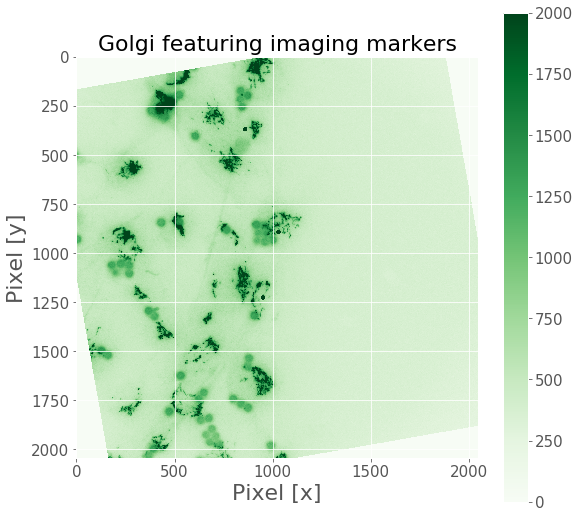

In [89]:
imdir = 'C:/Users/letmedoit/endothelial Polarization-exp 1/processeddata/Animal-1-2hrs-marked/'
image_array_GBR_with_markers = io.imread(imdir + 'Animal 1_2hrs_013-edit.tif')

green_array = image_array_GBR_with_markers[:,:,0]
show_image(image_array_GBR_with_markers[:,:,0],
           color='green', title='Golgi featuring imaging markers', vmax=2000)

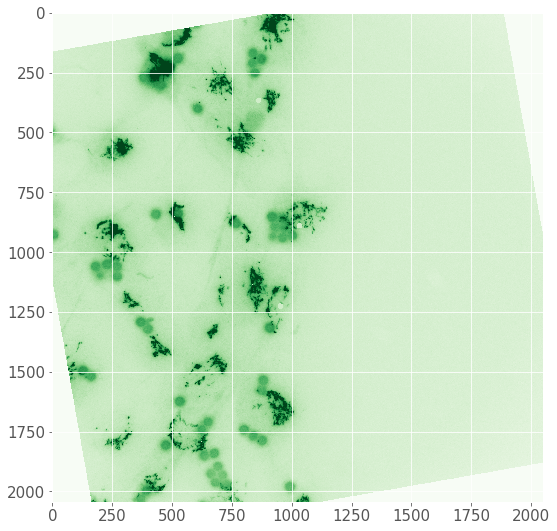

In [181]:
image_no_spray = remove_spray_can_feature(green_array, spray_can_value)
plt.figure(figsize=(9,9))
plt.imshow(image_no_spray, cmap='Greens', vmax=2000)

3


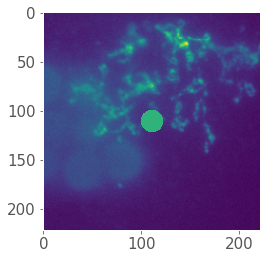

In [102]:
spray_can_value = get_spray_can_value(green_image_array=green_array)
    
spray_can_centers_array = get_spray_can_centers(green_array,
                                                    spray_can_value,
                                                    want_plots=False)
print(len(spray_can_centers_array))

ROI = get_ROI_pixels(green_array, spray_can_centers_array[1])
# Remove the spray-can feature from the region of interest
ROI_no_spray = remove_spray_can_feature(image_array=ROI,
                                    spray_can_value=spray_can_value)
plt.imshow(ROI)
plt.grid('off')

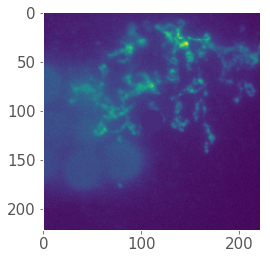

In [103]:
plt.imshow(ROI_no_spray)
plt.grid('off')

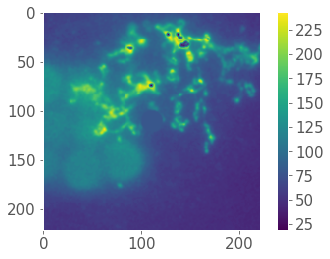

In [170]:
import cv2

img8 = (ROI_no_spray/10).astype('uint8')
#frame = cv2.GaussianBlur(img8, (3,3), 0)
plt.imshow(frame)
plt.colorbar()
plt.grid('off')


243
6


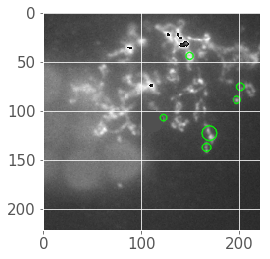

In [177]:

markerMin = 90
markerMax = 200

mask = cv2.inRange(img8, markerMin, markerMax)

params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 20

params.filterByCircularity = True
params.minCircularity = 0.5

params.filterByConvexity = True
params.minConvexity = 0.5

detector = cv2.SimpleBlobDetector_create(params)
print(np.max(frame))
keypoints = detector.detect(255-mask)
print(len(keypoints))
im_with_keypoints = cv2.drawKeypoints(img8, keypoints,
                                      np.array([]),
                                      (0,255,0),
                                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(mask)
#plt.imshow(frame)
plt.imshow(im_with_keypoints)
#plt.imshow()
#plt.imshow(im_with_keypoints)    
#plt.imshow(keypoints)
#plt.imshow('mask', mask)
#plt.show()



In [32]:
import numpy as np
import numpy.linalg as LA

def angles_from_points(A, B, origin):
    """ Returns the angles [rad] between two points.
    
    Keyword arguments:
    A: a 1-D numpy array with elements in the form [x,y]
    B: a 1-D numpy array with elements in the form [x,y]
    origin: a 1-D numpy array with elements in the form [x,y]
    
    We use the dot product between two Euclidean vectors A and B
    to determine the angle between them.
    
    N.B. we assume that A contains the coordinates for the 
    Golgi centroids. 
    """
    A_vectors = A - origin
    B_vectors = B - origin
    
    magA = LA.norm(A_vectors, axis=1)
    magB = LA.norm(B_vectors, axis=1)
    
    dotAB = np.sum(A_vectors*B_vectors, axis=1)
    cosTheta = dotAB / (magA*magB)
    
    # Compare y-values to see whether the angle should be negative
    A_greater_than_B = np.greater(A_vectors[:,1], B_vectors[:,1]) 
    
    signs = np.array([1 if element else -1 
                     for element in A_greater_than_B])
    
    return signs*np.arccos(cosTheta)

In [ ]:
import numpy as np
import numpy.linalg as LA
### Importing tiff stack images with skimage.io.imread
from skimage import io

#imdir = 'C:/Users/letmedoit/endothelial Polarization-exp 1/Animal 1- 4hrs-marked/'
import glob
import os

def main():
    main_dir = 'C:/Users/letmedoit/endothelial Polarization-exp 1/'
    data_dir = main_dir + 'processeddata/'
    
    ### Create a directory for output files 
    output_dir = main_dir + 'output/'
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    ### Given a directory, get all of the image files.
    image_file_list = glob.glob(data_dir + '**/*.tif')
    # ['.../processeddata\\Animal-1-2hrs-marked\\Animal 1_2hrs_003-edit.tif', ...]

    image_file_list = [imagefile.replace('\\', '/')
                  for imagefile in image_file_list]
    # ['.../processeddata/Animal-1-2hrs-marked/Animal 1_2hrs_003-edit.tif', ...]

    image_ID = [image.split("/", -1)[-1].split("-edit.tif")[0]
               for image in image_file_list]
    # ['Animal 1_2hrs_003', ...]
    
    hours = [ID.split(" ", -1)[1].split("_", 2)[1].split("hrs")[0]
             for ID in image_ID]
    # ['2', ...]
    
    ### Initialize the lists for holding output data
    nuclei_centroids = []
    golgi_centroids = []
    spray_can_centroids = []
    golgi_area = []
    golgi_perimeter = []

    n_files = len(image_file_list)
    
    ### loop through the images
    for i, image in enumerate(image_file_list):
        # The order of the tiff stack goes Green, Blue, Red
        
        print(image)
        image_array_GBR = io.imread(image)
        
        green_array = image_array_GBR[:,:,0]
        
        if (i % 10) == 0:
            print("{}/{}".format(i, n_files))
        areas, centroids, perimeters, spray_can_centers_array = analyze_Golgi(
            green_array, want_plots=True,
            out_dir=output_dir,
            image_name = image_ID[i])
        
        golgi_area.append(areas)
        golgi_centroids.append(centroids)
        golgi_perimeter.append(perimeters)
        spray_can_centroids.append(spray_can_centers_array)
        
        
        #blue_array = image_array_GBR[:,:,1]
        #print(blue_array.dtype, blue_array.shape,
        #      blue_array.min(), blue_array.max())
        # redarray can sit around and look pretty
        
        
    """
    nuclei_centroids = np.array(nuclei_centroids)
    golgi_centroids = np.array(golgi_centroids)
    
    angles = determineAnglesFromPoints(nuclei_centroids,
                                        golgi_centroids,
                                        spray_paint_centroids)
    
    
    ### Combine the data into a dataframe
    d = {'imageID' : image_ID,
        'nucleiCentroidsInPixels' : nuclei_centroids,
        'golgiCentroidsInPixels' : golgi_centroids,
        'ROICentroidsInPixels' : spray_paint_centroids,
        'golgiAreaInSquareMicrons' : golgi_area,
        'golgiPerimeterInMicrons' : golgi_perimeter
        'angle' : angles}
    df = pd.DataFrame(data=d)
    
    ### Write data to csv file
    csvfilename = 'C:/Users/letmedoit/endothelial Polarization-exp 1/data.csv'
    df.to_csv(csvfilename)
    
    ### Scatter matrix, etc.
    """
if __name__ == '__main__':
    main()

In [33]:
testA = np.array([[1., 0], [0, 1], [1, 1], [1, 0]])
testB = np.array([[0.5, 0.5], [1, 0], [1,0], [1,-1]])
origins = np.zeros_like(testA)

angles_from_points(testA, testB, origins)*180./np.pi

array([-45.,  90.,  45.,  45.])